### In this notebook, we perform permutation tests to qualitatively gauge the significance/confidence level of the decision boundary that separates the original samples from the mice brain vasculature from their shuffled counterparts

#### Import packages

In [1]:
import gudhi.representations
import gudhi as gd
import numpy as np
from numpy import random
import math
from ediblepickle import pickle
import os
import seaborn as sns
import matplotlib.pyplot as plt
import time
import csv
from persim.persistent_entropy import *
from scipy import stats

sns.set_style('darkgrid')

#### Get the filenames and locations to load the persistence diagram datasets

In [2]:
directory_in_str = '../data/annotated_PH_2020_500/'

directory = os.fsencode(directory_in_str)
folders=[]

for folder in os.listdir(directory):
    foldername = os.fsdecode(folder)
    if foldername.startswith('PH_640_'):
        folders.append(foldername)

#### Get persistence data stored in files within the folder whose location is passed through the keyword argument path

In [3]:
number_of_edges_threshold = 0

"""
Returns persistence data
Inputs -- path: local_path
       -- starts_with: the string that the filenames start with if needed
       -- ends_with: the string that the filenames end with if needed
       -- threshold: number of edges threshold of the underlying vascular networks
"""

def get_data(path=None,starts_with=None,ends_with=None,threshold=None):
    files = [os.fsdecode(file) for file in os.listdir(path)]
    persistence_data={}
    for filename in files:
        if starts_with and ends_with:
            if filename.startswith(starts_with) and filename.endswith(ends_with):
                data = []
                with open(path+filename) as f:
                    reader = csv.reader(f)
                    for row in reader:
                        data.append([float(x) for x in row])
                if data[0][1] >= threshold:
                    persistence_data[filename]=[item for item in data[1:] if item[1]!=np.inf]
        elif starts_with:
            if filename.startswith(starts_with):
                data = []
                with open(path+filename) as f:
                    reader = csv.reader(f)
                    for row in reader:
                        data.append([float(x) for x in row])
                if data[0][1] >= threshold:
                    persistence_data[filename]=[item for item in data[1:] if item[1]!=np.inf]
        elif ends_with:
            if filename.endswith(ends_with):
                data = []
                with open(path+filename) as f:
                    reader = csv.reader(f)
                    for row in reader:
                        data.append([float(x) for x in row])
                if data[0][1] >= threshold:
                    persistence_data[filename]=[item for item in data[1:] if item[1]!=np.inf]
                
    return persistence_data

In [4]:
og_PHs={}
for folder in folders:
    og_PHs[folder] = get_data('../data/annotated_PH_2020_500/'+folder+'/',starts_with=('ph_'),threshold=number_of_edges_threshold)

shuffled_PHs={}
for folder in folders:
    shuffled_PHs[folder] = get_data('../data/annotated_PH_2020_500/'+folder+'/',starts_with=('shuffled_ph_'),threshold=number_of_edges_threshold)

#### Use the following helper function to get persistence data, which is stored within a dictionary of dictinoaries.

In [5]:
def get_pd_aslist(persistence_data):
    pd_data = []
    for key,value in persistence_data.items():
        if value:
            for subkey,subvalue in value.items():
                pd_data.append(subvalue)
                if not subvalue:
                    print(subkey)
    return pd_data

#### Loading the persistence data, downsampling (optional) and creating the labels for classification

In [6]:
og_ph_dataset = get_pd_aslist(og_PHs)
shuffled_ph_dataset = get_pd_aslist(shuffled_PHs)

y=[]
for k in range(len(og_ph_dataset)+len(shuffled_ph_dataset)):
    if k < len(og_ph_dataset):
        y.append(0)
    elif k >= len(og_ph_dataset):
        y.append(1)
        
dataset = [np.array(item) for item in og_ph_dataset+shuffled_ph_dataset]

print((sum(y)/len(y),len(y)))

(0.5, 204)


#### Persistence landscapes. 

Persistence landscapees are piecewise linear functions that are generated using persistence diagrams. These are vectors in a Hilbert space and thus are amenable to training a machine learning algorithm (https://jmlr.org/papers/v16/bubenik15a.html).

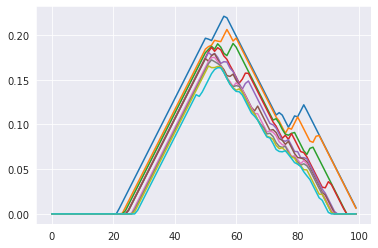

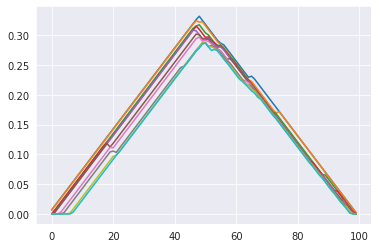

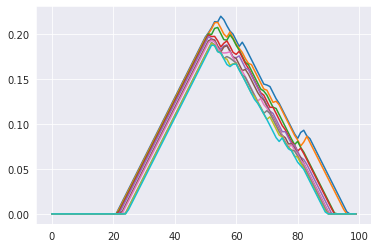

In [7]:
## Specify the resolution of the landscapes 
resolution = 100
## Specify the number of landscapes. The order of landscapes is inversely proportional to their persistence. 
num_landscapes = 10
LS = gd.representations.Landscape(resolution = resolution,num_landscapes=num_landscapes)
K = LS.num_landscapes

## Plot landscapes from region-2
L = LS.fit_transform([dataset[-3],dataset[-1],dataset[-2]])
for idx, landscape in enumerate(L):
    for k in range(K):
        plt.plot(landscape[k*resolution: (k+1)*resolution])
    plt.show()

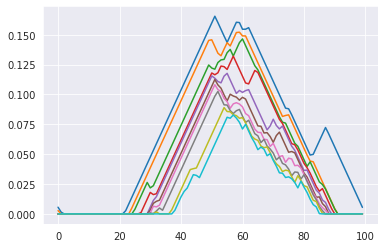

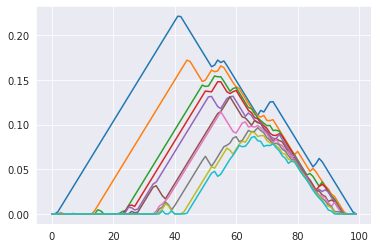

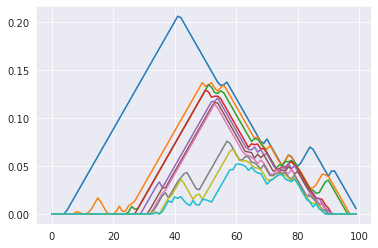

In [8]:
## Plot landscapes from region-2
L = LS.fit_transform([dataset[3],dataset[1],dataset[2]])
for idx, landscape in enumerate(L):
    for k in range(K):
        plt.plot(landscape[k*resolution: (k+1)*resolution])
    plt.show()

Train-test split (optional)

In [9]:
# from sklearn.model_selection import train_test_split

# ph_train, ph_test, y_train, y_test = train_test_split(dataset, y,
#                                                       test_size = 0.1,
#                                                       random_state=100,
#                                                       shuffle=True,
#                                                       stratify=y)

Create the pipeline

In [10]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV


pipe = Pipeline(steps=[
    ('scaler',gd.representations.DiagramScaler(scalers=[([0,1], MinMaxScaler())])),
    ('tda',gd.representations.Landscape(resolution = 10,\
                                            num_landscapes = 10)),
    ('classifier',LinearSVC(max_iter=50000))
])


param_grid = {
    'classifier__C':np.logspace(-2,3,10) 
}

model = GridSearchCV(pipe, param_grid, n_jobs=12, cv = 10, scoring='accuracy')

Training and testing/validation

In [11]:
start = time.perf_counter()
model.fit(dataset,y)
finish = time.perf_counter()
print(f'time taken : {finish-start}s')

print(model.best_score_)
print(model.best_params_)

# print(accuracy_score(y_test,model.predict(ph_test)))

time taken : 42.98927122913301s
0.9952380952380953
{'classifier__C': 5.994842503189409}


#### Permutation test (https://en.wikipedia.org/wiki/Permutation_test)

In [12]:
# significance = accuracy_score(y_test,model.predict(ph_test))
significance = model.best_score_
print(significance)
n=len(y)
sig_count = 0
num_perms=100
sigs=[]

for k in range(num_perms):
    new_indices = list(range(n))
    random.shuffle(new_indices)
    
    new_X = dataset.copy()
    new_y = [y[i] for i in new_indices] 
    new_ph_train, new_ph_test, new_y_train, new_y_test = train_test_split(new_X, new_y,
                                                      test_size = 0.1,
                                                      random_state=100,
                                                      shuffle=True,
                                                      stratify=new_y)

    new_model = Pipeline(steps=[
        ('scaler',gd.representations.DiagramScaler(scalers=[([0,1], MinMaxScaler())])),
        ('tda',gd.representations.Landscape(resolution = 10,\
                                            num_landscapes = 10)),
        ('classifier',LinearSVC(C=model.best_params_['classifier__C'],max_iter=50000))
    ])
    
    new_model.fit(new_ph_train,new_y_train)
    sig = accuracy_score(new_y_test,new_model.predict(new_ph_test))
    if (sig >= significance): sig_count += 1
    sigs.append(sig)
    print(sig)

pval = sig_count/num_perms

print(f'There were {sig_count} shuffles out of {num_perms} that',
     'were more significant than the true labelling. Thus, the',
     f'p-value is {pval}.')

0.9952380952380953
0.47619047619047616
0.5714285714285714
0.47619047619047616
0.47619047619047616
0.5714285714285714
0.6666666666666666
0.47619047619047616
0.5238095238095238
0.6190476190476191
0.5238095238095238
0.5238095238095238
0.5238095238095238
0.47619047619047616
0.47619047619047616
0.5238095238095238
0.47619047619047616
0.47619047619047616
0.7142857142857143
0.7619047619047619
0.5714285714285714
0.7619047619047619
0.5714285714285714
0.6190476190476191
0.6666666666666666
0.5238095238095238
0.5238095238095238
0.42857142857142855
0.5238095238095238
0.5238095238095238
0.6190476190476191
0.2857142857142857
0.5238095238095238
0.5714285714285714
0.42857142857142855
0.42857142857142855
0.42857142857142855
0.42857142857142855
0.6190476190476191
0.5714285714285714
0.5238095238095238
0.47619047619047616
0.2857142857142857
0.3333333333333333
0.7142857142857143
0.47619047619047616
0.5714285714285714
0.42857142857142855
0.47619047619047616
0.38095238095238093
0.47619047619047616
0.6666666666

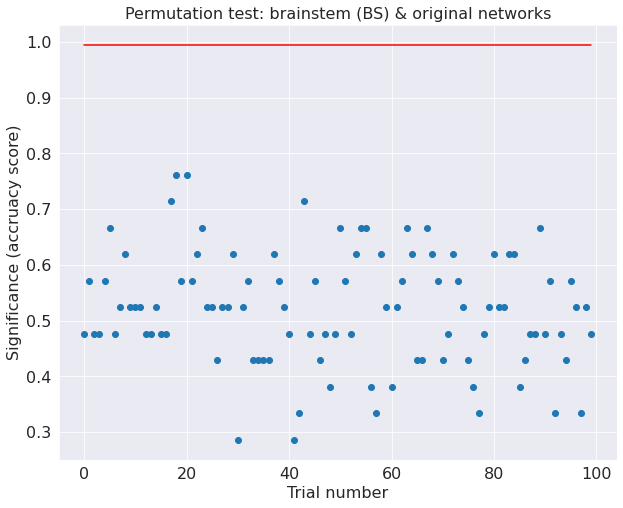

In [13]:
plt.figure(figsize=(10,8))

plt.scatter(range(num_perms),sigs)

plt.plot(range(num_perms),np.ones(num_perms)*significance, color='red');

plt.xlabel("Trial number",fontsize=16)
plt.ylabel("Significance (accruacy score)",fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Permutation test: brainstem (BS) & original networks',fontsize=16)
plt.savefig('permutation_test_brainstem.jpg');